<a href="https://colab.research.google.com/github/thetwinsk/DeepLearningNLP/blob/main/Identify_spam_in_popular_YouTube_videos_comments_with_LSTM_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/DeepLearning/NLP LSTM/

/content/drive/My Drive/DeepLearning/NLP LSTM


In [3]:
import pandas as pd

In [4]:
import zipfile
ZIP_FILE = 'YouTube-Spam-Collection-v1.zip'
DIR_TO_EXTRACT = '/content/drive/My Drive/DeepLearning/NLP LSTM/'

In [5]:
#Extract the Data
zip_ref = zipfile.ZipFile(ZIP_FILE, 'r')
zip_ref.extractall(DIR_TO_EXTRACT)
zip_ref.close()

In [6]:
ls

'Identify spam in popular YouTube videos comments with LSTM - Keras.ipynb'
 __MACOSX/
 Youtube01-Psy.csv
 Youtube02-KatyPerry.csv
 Youtube03-LMFAO.csv
 Youtube04-Eminem.csv
 Youtube05-Shakira.csv
 YouTube-Spam-Collection-v1.zip


In [7]:
comments_df_list = []
comments_file = ['Youtube01-Psy.csv', 
                 'Youtube02-KatyPerry.csv', 
                 'Youtube03-LMFAO.csv',
                 'Youtube04-Eminem.csv',
                 'Youtube05-Shakira.csv']
for f in comments_file:
  df = pd.read_csv(f, header=0)
  comments_df_list.append(df)
comments_df = pd.concat(comments_df_list)
comments_df = comments_df.sample(frac=1.0)
print(comments_df.shape)
comments_df.head()

(1956, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
14,z13jtfwiuwrvy1tng23gid4hesqwxl4cm,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,1
29,z13tv3oqtkz0exqhg04cjfgqlyrgipmou20,vuong quang,2015-05-26T14:53:14.277000,Like﻿,0
58,z13uw5rqqwu4ufqli224fvzryy2vwlyk4,MmmHmmm,2015-05-24T20:38:33.832000,Lamest World Cup song ever! This time FOR Afri...,0
123,z12vibnqjrygfn0p404cc1loanvyw54pcmw0k,Nathan Waterhouse,2014-09-16T14:21:04,Please check out my acoustic cover channel :) ...,1
424,z13gxxlhyrmccf10422gdrogiwbjtfwjb04,Ahmed Medhat,2015-05-19T15:23:47.680000,Simply rap god﻿,0


In [8]:
comments_df.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')

In [9]:
df = comments_df.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 14 to 142
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1956 non-null   object
 1   CLASS    1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


In [10]:
df['V1'] = df['CLASS'].map(lambda x: 'ham' if x==0 else 'spam')
df.head()

,CONTENT,CLASS,V1
14,https://soundcloud.com/artady please check my ...,1,spam
29,Like﻿,0,ham
58,Lamest World Cup song ever! This time FOR Afri...,0,ham
123,Please check out my acoustic cover channel :) ...,1,spam
424,Simply rap god﻿,0,ham


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'The number of ham-0 & spam-1')

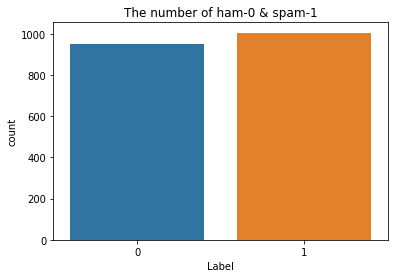

In [12]:
sns.countplot(df.CLASS)
plt.xlabel('Label')
plt.title('The number of ham-0 & spam-1')

In [13]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(df.CONTENT, df.CLASS, test_size=0.15)

In [14]:
train_X.shape

(1662,)

In [15]:
valid_X.shape

(294,)

In [16]:
train_y.shape

(1662,)

# Process the data

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import rmsprop_v2
from sklearn import metrics
from keras.callbacks import EarlyStopping

In [19]:
max_words = 1000
max_len = 150
token = Tokenizer(num_words=max_words)
token.fit_on_texts(train_X)
sequences = token.texts_to_sequences(train_X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

# RNN

In [20]:
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [21]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentrophy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [22]:
from keras.optimizer_v2.rmsprop import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [23]:
model.fit(sequences_matrix, train_y,
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
11/11 [==============================] - 10s 406ms/step - loss: 0.6460 - accuracy: 0.6682 - val_loss: 0.5166 - val_accuracy: 0.8108
Epoch 2/10
11/11 [==============================] - 3s 299ms/step - loss: 0.4081 - accuracy: 0.8706 - val_loss: 0.2746 - val_accuracy: 0.9129


In [24]:
test_sequences = token.texts_to_sequences(valid_X)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [25]:
accuracy = model.evaluate(test_sequences_matrix, valid_y)

10/10 [==============================] - 0s 26ms/step - loss: 0.2980 - accuracy: 0.9082


In [26]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accuracy[0], accuracy[1]))

Test set
 Loss: 0.298
 Accuracy: 0.908
